In [1]:
'''
TODO:
1. Нормализовать значения
2. Удалить схемы
3. Освещение и тяжесть -> int

PROBLEMS:


Границы СПб:
            from        to
latitude    59.63       60.24
longitude   29.42       30.76
'''

'\nTODO:\n1. Нормализовать значения\n2. Удалить схемы\n3. Освещение и тяжесть -> int\n\nPROBLEMS:\n\n\nГраницы СПб:\n            from        to\nlatitude    59.63       60.24\nlongitude   29.42       30.76\n'

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from io import StringIO
from csv import writer
from IPython.display import display, HTML
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [3]:
# функция для преобразования кода съемы в HTML-код изображения на сервере сайта dtp-stat.ru

def path_to_image_html(path):
    return '<img src="https://dtp-stat.ru/static/scheme/'+ path + '.png">'

In [4]:
# функция для подготовки One-Hot кодирования столбца, в котором данные имеют вид списков
# возвращает набор присутствующих значений и DataFrame-объект закодированной таблицы 

def one_hot_prepare(datacol):      
    ohe_cols = []
    for value in datacol.values:
        for i in range(len(value)):
            if value[i] not in ohe_cols:
                ohe_cols.append(value[i])
                
    res = dict(zip(ohe_cols, [[None]*len(datacol) for _ in ohe_cols]))
    
    for i, value in enumerate(datacol):
        for col in ohe_cols:
            if col in value:
                res[col][i] = 1
            else:
                res[col][i] = 0      
    return ohe_cols, res
    

In [5]:
# функция для осуществления One-Hot кодирования указанных столбцов в заданной таблице

def one_hot_encoding(data, columns):
    for column in columns:
        ohe_headers, ohe_data = one_hot_prepare(data[column])
        for header in ohe_headers:
           data[header] = ohe_data[header]
        data = data.drop(columns=column)
    return data        

In [6]:
with open("spb.geojson", encoding='utf-8') as f:
    data = pd.read_json(f)

In [7]:
# извлекаем нужные данные путём нормализации json'a
# в несколько этапов - для того, чтобы не было лишних префиксов

data = pd.json_normalize(data['features'], sep='_', max_level=0)
data = pd.json_normalize(data['properties'], sep='_')

In [8]:
# удаляем лишние столбцы и фильтруем данные, оставляя связанные с перекрёстками (согласно схемам)

cutted = data.drop(columns=['id', 'gibdd_id', 'participant_categories', 'parent_region', 'address', 'vehicles', 'participants', 'tags'])
cutted.dropna(inplace=True)
scheme_filter = ['100', '110', '120', '130', '300', '310', '320', '340', '400', '410', '420', '430', '440', 
                 '700', '710', '720', '730', '760', '770', '780']
cutted = cutted[cutted.scheme.isin(scheme_filter)]

In [9]:
# удаляем всё, что за пределами СПб по координатам

lat_min = 59.63
lat_max = 60.24
long_min = 29.42
long_max = 30.76
cutted = cutted[(cutted.point_lat > lat_min) & (cutted.point_lat < lat_max) &
                (cutted.point_long > long_min) & (cutted.point_long < long_max)]

In [10]:
# визуализируем схемы ДТП

pd.set_option('display.max_colwidth', None)
format_dict = {'scheme': path_to_image_html}
display(HTML(cutted.tail(3).to_html(escape=False ,formatters=format_dict)))

,severity,region,datetime,participants_count,injured_count,dead_count,category,light,nearby,weather,road_conditions,scheme,point_lat,point_long
39445,Тяжелый,Адмиралтейский район,2017-02-13 14:40:00,2,1,0,Наезд на пешехода,Светлое время суток,"[Мост, Регулируемый пешеходный переход]",[Пасмурно],[Мокрое],,59.908300,30.27610
39446,Легкий,Адмиралтейский район,2017-02-24 21:00:00,2,1,0,Наезд на пешехода,"В темное время суток, освещение включено","[Многоквартирные жилые дома, Регулируемый пешеходный переход]",[Пасмурно],[Мокрое],,59.924190,30.30814
39447,Легкий,Адмиралтейский район,2017-02-21 01:00:00,2,1,0,Наезд на пешехода,Светлое время суток,"[Многоквартирные жилые дома, Нерегулируемый пешеходный переход]",[Пасмурно],[Мокрое],,59.914313,30.29749


In [11]:
# преобразуем datetime в месяц, день недели и время

datetime = cutted['datetime']
month = []
day = []
timestamp = []
for row in datetime:
    day.append(pd.to_datetime(row).dayofweek)
    row = row.split(' ')
    month.append(row[0].split('-')[1])
    time = row[1][:-3].split(':')
    timestamp.append(int(time[1]) + int(time[0]) * 60)
    

cutted['month'] = month
cutted['day'] = day
cutted['timestamp'] = timestamp
cutted = cutted.drop(columns='datetime')

In [12]:
# приводим категориальные переменные к формату числовых с помощью One-Hot кодирования

# result = pd.get_dummies(cutted, columns=['category'], prefix=['Категория'])
result = one_hot_encoding(cutted, ['weather', 'nearby', 'road_conditions'])

In [13]:
daylight = 'Светлое время суток'
twilight = 'Сумерки'
night_light_wo = 'В темное время суток, освещение отсутствует'
night_light_off = 'В темное время суток, освещение не включено'
night_light_on = 'В темное время суток, освещение включено'
result['light'] = result['light'].map({daylight: 10, twilight: 5, night_light_on: 3, night_light_off: 0, night_light_wo: 0})
result = result.drop(columns=['region', 'category'])
result.tail(3)

,severity,participants_count,injured_count,dead_count,light,scheme,point_lat,point_long,month,day,...,Неудовлетворительное состояние обочин,Отсутствие временных ТСОД в местах проведения работ,Свежеуложенная поверхностная обработка,Со снежным накатом,Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям,Отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта,Низкие сцепные качества покрытия,Неисправное освещение,Ограничение видимости,"Отклонение верха головки рельса трамвайных (железнодорожных) путей, расположенных в пределах проезжей части, относительно покрытия, более чем на 2,0 см"
39445,Тяжелый,2,1,0,10,700,59.908300,30.27610,02,0,...,0,0,0,0,0,0,0,0,0,0
39446,Легкий,2,1,0,3,730,59.924190,30.30814,02,4,...,0,0,0,0,0,0,0,0,0,0
39447,Легкий,2,1,0,10,700,59.914313,30.29749,02,1,...,0,0,0,0,0,0,0,0,0,0


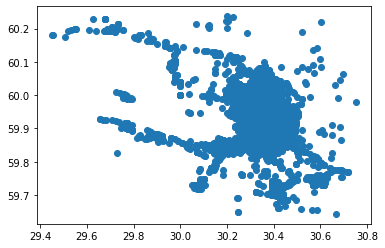

In [14]:
# строим карту записей: видно, что охвачен почти весь город

x = result[['point_lat', 'point_long']].round(4)
# transformer = Normalizer().fit(x)
# normalized = transformer.transform(x)
plt.scatter(x['point_long'], x['point_lat'])

In [15]:
# расчет тяжести аварии

result['severity'] = result['participants_count'] * 1 + result['injured_count'] * 5 + result['dead_count'] * 70
result = result.drop(columns=['participants_count', 'injured_count', 'dead_count'])
result = result.drop(columns=['scheme'])

severity = result['severity']

result.tail(3)

,severity,light,point_lat,point_long,month,day,timestamp,Ясно,Пасмурно,Снегопад,...,Неудовлетворительное состояние обочин,Отсутствие временных ТСОД в местах проведения работ,Свежеуложенная поверхностная обработка,Со снежным накатом,Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям,Отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта,Низкие сцепные качества покрытия,Неисправное освещение,Ограничение видимости,"Отклонение верха головки рельса трамвайных (железнодорожных) путей, расположенных в пределах проезжей части, относительно покрытия, более чем на 2,0 см"
39445,7,10,59.908300,30.27610,02,0,880,0,1,0,...,0,0,0,0,0,0,0,0,0,0
39446,7,3,59.924190,30.30814,02,4,1260,0,1,0,...,0,0,0,0,0,0,0,0,0,0
39447,7,10,59.914313,30.29749,02,1,60,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
severity = np.array(severity)

In [17]:
# нормализация данных

scaler = MinMaxScaler()
scaler.fit(result)
scaled = scaler.fit_transform(result)
scaled_result = pd.DataFrame(scaled, columns=result.columns)
scaled_result = scaled_result.drop(columns='severity')
scaled_result.tail(3)

,light,point_lat,point_long,month,day,timestamp,Ясно,Пасмурно,Снегопад,Дождь,...,Неудовлетворительное состояние обочин,Отсутствие временных ТСОД в местах проведения работ,Свежеуложенная поверхностная обработка,Со снежным накатом,Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям,Отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта,Низкие сцепные качества покрытия,Неисправное освещение,Ограничение видимости,"Отклонение верха головки рельса трамвайных (железнодорожных) путей, расположенных в пределах проезжей части, относительно покрытия, более чем на 2,0 см"
8145,1.0,0.446395,0.633499,0.090909,0.000000,0.611961,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8146,0.3,0.473162,0.658061,0.090909,0.666667,0.876217,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8147,1.0,0.456524,0.649897,0.090909,0.166667,0.041725,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# взвешивание и нормализация

weighted = scaled_result.mul(severity, axis=0)

scaler.fit(weighted)
scaled = scaler.fit_transform(weighted)
scaled_result = pd.DataFrame(scaled, columns=weighted.columns)
scaled_result.tail(3)

,light,point_lat,point_long,month,day,timestamp,Ясно,Пасмурно,Снегопад,Дождь,...,Неудовлетворительное состояние обочин,Отсутствие временных ТСОД в местах проведения работ,Свежеуложенная поверхностная обработка,Со снежным накатом,Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям,Отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта,Низкие сцепные качества покрытия,Неисправное освещение,Ограничение видимости,"Отклонение верха головки рельса трамвайных (железнодорожных) путей, расположенных в пределах проезжей части, относительно покрытия, более чем на 2,0 см"
8145,0.046667,0.030294,0.033270,0.004348,0.000000,0.028614,0.0,0.044872,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8146,0.014000,0.032110,0.034560,0.004348,0.030108,0.040970,0.0,0.044872,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8147,0.046667,0.030981,0.034131,0.004348,0.007527,0.001951,0.0,0.044872,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# факторный анализ полного датасета и определение вклада изначальных переменных в состояние системы
# уменьшения размерности пространства не происходит

pca = PCA()
pca.fit(scaled_result)
num = pca.components_.shape[0]

impact = np.zeros(num)
for i in range(len(pca.explained_variance_ratio_)):
    for j in range(len(pca.components_[i])):
        impact[j] += abs(pca.components_[i][j] * pca.explained_variance_ratio_[i])
        
dic = {scaled_result.columns[i]: impact[i] for i in range(num)}
dic = dict(sorted(dic.items(),key= lambda x:x[1], reverse=True))


# fig = plt.gcf()
# fig.set_size_inches(30, 20)
# sns.heatmap(pd.DataFrame(pca.components_, columns=list(scaled_result.drop(columns='severity').columns)).abs())
# fig.savefig('a.png')

In [20]:
dic

{'Регулируемый перекресток': 0.16458297731690158,
 'Регулируемый пешеходный переход': 0.15796786423968626,
 'Сухое': 0.1419198847447639,
 'light': 0.1414187845818728,
 'month': 0.13764719893823565,
 'Пасмурно': 0.1337313587085199,
 'point_lat': 0.13123854995953763,
 'Остановка общественного транспорта': 0.12742704121441317,
 'point_long': 0.1265769711291049,
 'Отсутствие пешеходных ограждений в необходимых местах': 0.12509036258263836,
 'day': 0.12420479620983164,
 'Отсутствие, плохая различимость горизонтальной разметки проезжей части': 0.12223546412698462,
 'Ясно': 0.12219181014759231,
 'Мокрое': 0.12040758282092741,
 'timestamp': 0.11734537462195942,
 'Нерегулируемый пешеходный переход': 0.11061244278447827,
 'Многоквартирные жилые дома': 0.10947813196176032,
 'Отсутствие дорожных знаков в необходимых местах': 0.0893493705736958,
 'Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта)': 0.08124673893006475,
 'Нерегулируемый перекресток неравн

In [21]:
# факторный анализ, уменьшающий размерность пространства до первых 25 компонентов. фильтрация исходных переменных по пороговому значению вклада в систему

pca = PCA(n_components=25)
pca.fit(scaled_result)
num = pca.components_.shape[1]
print(sum(pca.explained_variance_ratio_))


impact = np.zeros(num)
for i in range(len(pca.explained_variance_ratio_)):
    for j in range(len(pca.components_[i])):
        impact[j] += abs(pca.components_[i][j] * pca.explained_variance_ratio_[i])
impact = impact.reshape(-1, 1)
scaler = MinMaxScaler()
scaler.fit(impact)
scaled = scaler.fit_transform(impact)
for i, col in enumerate(scaled_result.columns):
    pass
    # print(f'{col} --------> {impact[i][0]} \t {scaled[i]}')

cols_to_drop = [i for i in range(len(scaled)) if scaled[i] < 0.2]
scaled_result.drop(scaled_result.columns[cols_to_drop], axis=1, inplace=True)
# pca = PCA(n_components=len(scaled))
# pca.fit(scaled_result.drop(columns='severity'))
# num = pca.components_.shape[0]
# print(sum(pca.explained_variance_ratio_))

# fig = plt.gcf()
# fig.set_size_inches(30, 20)
# sns.heatmap(pd.DataFrame(pca.components_, columns=list(scaled_result.drop(columns='severity').columns)).abs())
# fig.savefig('a.png')

0.757462570256726


<AxesSubplot:>

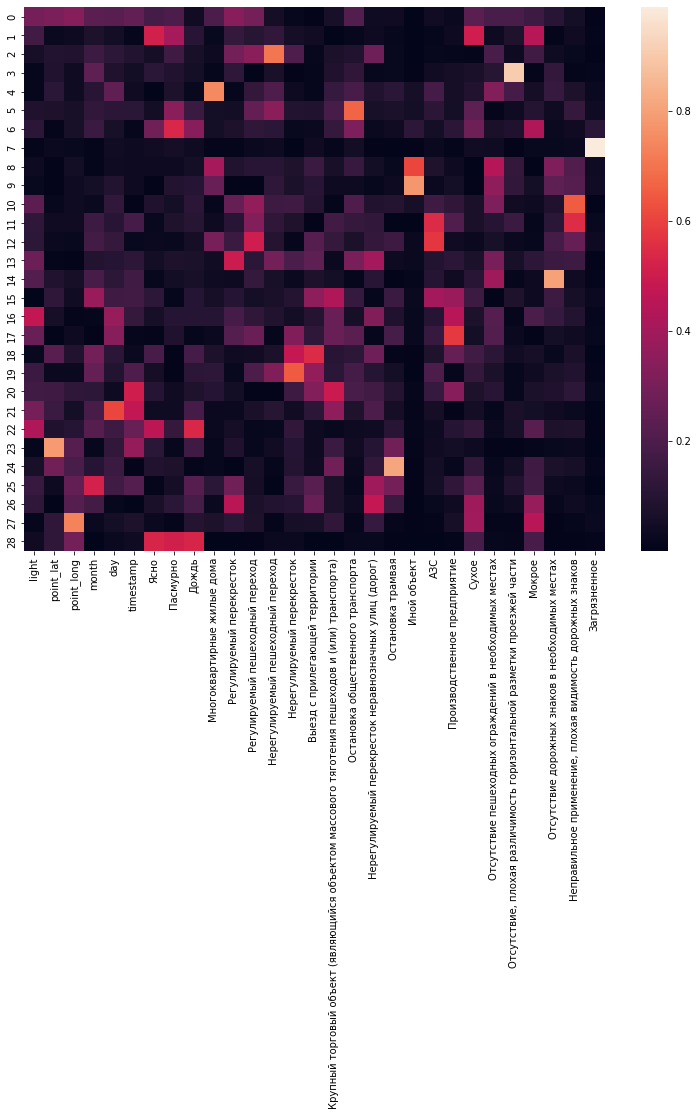

In [22]:
# построение хитмапа

pca = PCA(n_components=len(scaled_result.columns))
pca.fit(scaled_result)

fig = plt.gcf()
fig.set_size_inches(13, 10)
sns.heatmap(pd.DataFrame(pca.components_, columns=list(scaled_result.columns)).abs())

In [23]:
# выделение наиболее значимых факторов (компонент) и основных их составляющих

comps = pca.components_
factors = [[] for _ in range(len(comps))]
for i in range(len(comps)):
    for j in range(len(comps[i])):
        if comps[i][j] > 0.3:
            factors[i].append(scaled_result.columns[j] + '+++')
        elif comps[i][j] < -0.3:
            factors[i].append(scaled_result.columns[j] + '---')
    print(f'Фактор {i} ({pca.explained_variance_ratio_[i]}): {factors[i]}')

Фактор 0 (0.3647909622104407): ['point_lat+++', 'point_long+++', 'Регулируемый перекресток+++']
Фактор 1 (0.09438133764830285): ['Ясно---', 'Пасмурно+++', 'Сухое---', 'Мокрое+++']
Фактор 2 (0.07412289499481355): ['Регулируемый пешеходный переход---', 'Нерегулируемый пешеходный переход+++']
Фактор 3 (0.05776119357121237): ['Отсутствие, плохая различимость горизонтальной разметки проезжей части---']
Фактор 4 (0.038254414010082734): ['Многоквартирные жилые дома---', 'Отсутствие пешеходных ограждений в необходимых местах---']
Фактор 5 (0.03441627691710976): ['Пасмурно+++', 'Нерегулируемый пешеходный переход---', 'Остановка общественного транспорта---']
Фактор 6 (0.03189349539692997): ['Пасмурно---', 'Дождь+++', 'Остановка общественного транспорта---', 'Мокрое+++']
Фактор 7 (0.02792947015675835): ['Загрязненное+++']
Фактор 8 (0.02687807098899747): ['Многоквартирные жилые дома+++', 'Иной объект+++', 'Отсутствие пешеходных ограждений в необходимых местах---', 'Отсутствие дорожных знаков в нео

In [30]:
# определение вклада оставшихся переменных в состояние системы 

impact = np.zeros(len(comps))
for i in range(len(pca.explained_variance_ratio_)):
    for j in range(len(comps[i])):
        impact[j] += abs(comps[i][j] * pca.explained_variance_ratio_[i])
for i in range(len(impact)):
    print(f'{scaled_result.columns[i]} \t {impact[i]}')

light 	 0.1785985263786853
point_lat 	 0.15578256782290031
point_long 	 0.15828603852045958
month 	 0.1671503356245886
day 	 0.16002688031832998
timestamp 	 0.14447989321148041
Ясно 	 0.15551513869085573
Пасмурно 	 0.17677999674215472
Дождь 	 0.08205768876207303
Многоквартирные жилые дома 	 0.14424985117174796
Регулируемый перекресток 	 0.20559477684918598
Регулируемый пешеходный переход 	 0.2045983672223462
Нерегулируемый пешеходный переход 	 0.14226470909052963
Нерегулируемый перекресток 	 0.0723345059416935
Выезд с прилегающей территории 	 0.060816276964925836
Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта) 	 0.09143821482032376
Остановка общественного транспорта 	 0.16694966087373356
Нерегулируемый перекресток неравнозначных улиц (дорог) 	 0.0838061839185788
Остановка трамвая 	 0.054131188449996356
Иной объект 	 0.05074259383130113
АЗС 	 0.08243369475760003
Производственное предприятие 	 0.06660642107146836
Сухое 	 0.18229889366159524


In [34]:
# определение координат перекрестков, на которых часты случаи дтп из-за фактора
# а ещё видно, что некоторые не запариваются и ставят координаты 60. 30.

bad_lines = result[result['Отсутствие, плохая различимость горизонтальной разметки проезжей части'] == 1]
x = bad_lines[['point_lat', 'point_long']].round(4)
x.value_counts()

point_lat  point_long
59.9002    30.4887       4
60.0000    30.0000       4
59.7464    30.5888       4
59.8929    30.4471       4
59.9147    30.3514       3
                        ..
59.8873    30.3440       1
59.8871    30.2683       1
59.8857    30.2671       1
59.8856    30.2670       1
60.2150    29.7334       1
Length: 1269, dtype: int64